# Horse vs Human classification but with augmentation and Dropout layer

Applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results because additional training data generated might still do not represent the features in the validation data.

For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that ImageDataGenerator provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping.

note: the background for all validation images are white background

But what if we add dropout?

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features, providing some specialization. Neighboring neurons come to rely on this specialization, which, if taken too far, can result in a fragile model too specialized for the training data. This reliance on context for a neuron during training is referred to as complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This, in turn, results in a network capable of better generalization and less likely to overfit the training data.

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/


In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory # 'tis a function
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
     
     

In [2]:
def create_model():
  ## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
  tf.random.set_seed(10)
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    ## add dropout here
    tf.keras.layers.Dropout(0.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model


def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()  

In [3]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
     

--2023-01-05 09:37:57--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  16.3MB/s    in 10s     

2023-01-05 09:38:08 (13.7 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2023-01-05 09:38:08--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [

In [4]:
# Extract the archive
zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
zip_ref.extractall('tmp/horse-or-human')

zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
zip_ref.extractall('tmp/validation-horse-or-human')

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')
     

In [36]:
# create generator that standardize pixel values
train_datagen = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rescale = 2/255., ## ad this to limit range from -1 to 1 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# of course we don't augment the validation dataset because it supposedly reflect outside or real life data
test_datagen  = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rescale = 2/255. ## ad this to limit range from -1 to 1
                                   )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        'tmp/validation-horse-or-human/',
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## tes data gen single image array

In [37]:
abc = np.random.randint(0,255, (1,300,300,3))
print(abc.shape)
print('train datagen')
for x_i in test_datagen.flow(abc, batch_size = 1):
  print('mean:',np.mean(x_i))
  print('min:',np.min(x_i))
  print('max:',np.max(x_i))
  break

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f mean=%.3f' % (batchX[0].shape, batchX[0].min(), batchX[0].max(), batchX[0].mean()))


(1, 300, 300, 3)
train datagen
mean: -1.1319761e-07
min: -1.7267067
max: 1.7267262
Batch shape=(300, 300, 3), min=-3.100, max=1.369 mean=0.000


In [38]:
abc = np.random.randint(0,255, (1,300,300,3))
print(abc.shape)
print('tes/validation datagen')
for x_i in train_datagen.flow(abc, batch_size = 1):
  print('mean:', np.mean(x_i))
  print('min:',np.min(x_i))
  print('max:',np.max(x_i))

  break

batchX, batchy = validation_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f mean=%.3f' % (batchX[0].shape, batchX[0].min(), batchX[0].max(), batchX[0].mean()))


(1, 300, 300, 3)
tes/validation datagen
mean: -1.8355757e-07
min: -2.42872
max: 2.4677143
Batch shape=(300, 300, 3), min=-2.652, max=0.553 mean=0.000


In [39]:
train_generator.n

1027

In [40]:
len(train_generator.labels)

1027

In [41]:

# Constant for epochs
EPOCHS = 20

train_steps_per_epoch = len(train_generator.labels)/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size

print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )
     

train_steps_per_epoch: 8.0234375
validation_steps_per_epoch: 8.0


In [42]:
# Create new model
model = create_model()
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps_per_epoch,  
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=validation_steps_per_epoch,  
      verbose=2)
     

Epoch 1/20
8/8 - 35s - loss: 0.6864 - accuracy: 0.6134 - val_loss: 0.5879 - val_accuracy: 0.7227 - 35s/epoch - 4s/step
Epoch 2/20
8/8 - 25s - loss: 0.6977 - accuracy: 0.5940 - val_loss: 0.5585 - val_accuracy: 0.7227 - 25s/epoch - 3s/step
Epoch 3/20
8/8 - 25s - loss: 0.5945 - accuracy: 0.7254 - val_loss: 0.5187 - val_accuracy: 0.7461 - 25s/epoch - 3s/step
Epoch 4/20
8/8 - 25s - loss: 0.5668 - accuracy: 0.7176 - val_loss: 0.6056 - val_accuracy: 0.7070 - 25s/epoch - 3s/step
Epoch 5/20
8/8 - 32s - loss: 0.5213 - accuracy: 0.7673 - val_loss: 0.8123 - val_accuracy: 0.6367 - 32s/epoch - 4s/step
Epoch 6/20
8/8 - 26s - loss: 0.5663 - accuracy: 0.7040 - val_loss: 0.4105 - val_accuracy: 0.8438 - 26s/epoch - 3s/step
Epoch 7/20
8/8 - 35s - loss: 0.5313 - accuracy: 0.7400 - val_loss: 0.6326 - val_accuracy: 0.7188 - 35s/epoch - 4s/step
Epoch 8/20
8/8 - 26s - loss: 0.4585 - accuracy: 0.8033 - val_loss: 0.7276 - val_accuracy: 0.7148 - 26s/epoch - 3s/step
Epoch 9/20
8/8 - 25s - loss: 0.4269 - accuracy: 

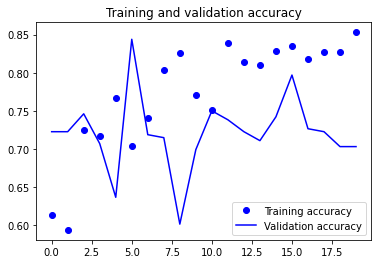

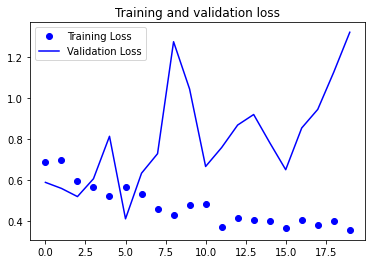

In [43]:

# Plot the results of training with data augmentation
plot_loss_acc(history)

Saving pexels-helena-lopes-1996333.jpg to pexels-helena-lopes-1996333 (1).jpg
(1, 300, 300, 3)
1/1 [==============================] - 0s 251ms/step
[0.6649024]
pexels-helena-lopes-1996333.jpg is a human


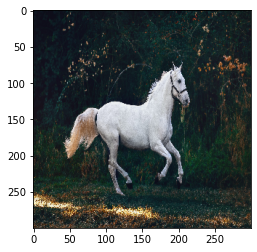

In [45]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    

    images = np.vstack([x_i])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
      print(fn + " is a human")
    else:
      print(fn + " is a horse")
    plt.imshow(img)
    break

Saving pexels-photo-10484491.jpeg to pexels-photo-10484491.jpeg
(1, 300, 300, 3)
1/1 [==============================] - 0s 16ms/step
[0.09206094]
pexels-photo-10484491.jpeg is a horse


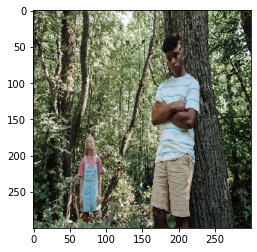

In [46]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    

    images = np.vstack([x_i])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
      print(fn + " is a human")
    else:
      print(fn + " is a horse")
    plt.imshow(img)
    break

Saving 1647228151484.jpg to 1647228151484.jpg
(1, 300, 300, 3)
(1, 300, 300, 3)
1/1 [==============================] - 0s 16ms/step
[0.515124]
1647228151484.jpg is a human


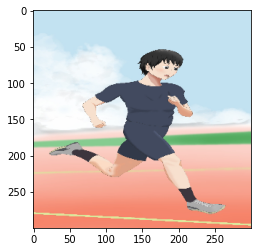

In [47]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    images = np.vstack([x_i])
    print(images.shape)
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    
    if classes[0]>0.5:
      print(fn + " is a human")
    else:
      print(fn + " is a horse")
    plt.imshow(img)
    break